# **Task 4: FICO Score Bucketing for Mortgage Default Risk**

## Business Context

The mortgage risk team believes that **FICO scores** are a strong indicator of whether a borrower will default on their mortgage.

However, the machine learning architecture used by the team **requires categorical variables**, while FICO scores are **continuous numerical values (300–850)**.

Therefore, we need to **convert FICO scores into discrete credit rating buckets** that:

- Preserve default risk information

- Are interpretable by business & regulators

- Can be reused for future datasets



#### **Objective**


- Convert FICO scores into risk-ordered buckets

- Ensure lower rating = better credit quality

- Compute Probability of Default (PD) per bucket

- Produce a rating map usable in downstream models

In [5]:
import pandas as pd
import numpy as np


In [9]:
df = pd.read_csv("Customer Loan Data.csv")
df.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


**Step 3: Focus Only on What We Need**

For this task, we only need:

- fico_score

- default

In [12]:
fico_df = df[['fico_score', 'default']].copy()
fico_df.head()


,fico_score,default
0,605,0
1,572,1
2,602,0
3,612,0
4,631,0


**Why Do We Bucket FICO Scores?**

If we directly use raw FICO scores:

- The model becomes too sensitive

- Small score changes can cause instability

- Harder to explain to regulators


**By bucketing:**

- Each bucket represents a credit rating

- Each rating has a stable PD

- The model becomes robust & interpretable

**Step 4: Basic Understanding of FICO Distribution**

In [15]:
fico_df['fico_score'].describe()


count    10000.000000
mean       637.557700
std         60.657906
min        408.000000
25%        597.000000
50%        638.000000
75%        679.000000
max        850.000000
Name: fico_score, dtype: float64

#### **Step 5: SIMPLE Bucketing (Baseline Approach)**

We start with **quantile-based bucketing**

This is easy and widely used as a baseline.

In [24]:
N_BUCKETS = 10

fico_df['fico_bucket'] = pd.qcut(
    fico_df['fico_score'],
    q=N_BUCKETS,
    labels=False
)


#### **Step 6: Ensure Correct Rating Direction**

We want:

- **Rating 0 = BEST credit**

- **Higher rating = worse credit**

In [28]:
fico_df['fico_bucket'] = fico_df['fico_bucket'].max() - fico_df['fico_bucket']


#### **Step 7: Analyze Default Rate per Bucket**

In [32]:
bucket_summary = (
    fico_df
    .groupby('fico_bucket')
    .agg(
        min_fico=('fico_score', 'min'),
        max_fico=('fico_score', 'max'),
        PD=('default', 'mean'),
        borrowers=('default', 'count')
    )
    .sort_index()
)

bucket_summary


,min_fico,max_fico,PD,borrowers
fico_bucket,,,,
0,715,850,0.036437,988
1,689,714,0.071642,1005
2,671,688,0.094845,970
3,654,670,0.105161,1027
4,639,653,0.128385,997
5,624,638,0.174395,992
6,608,623,0.181911,984
7,588,607,0.249240,987
8,561,587,0.307841,1033


| Rating | FICO Range | PD        |
| ------ | ---------- | --------- |
| 0      | 715–850    | **3.6%**  |
| 1      | 689–714    | 7.1%      |
| 2      | 671–688    | 9.4%      |
| 3      | 654–670    | 10.5%     |
| 4      | 639–653    | 12.8%     |
| 5      | 624–638    | 17.4%     |
| 6      | 608–623    | 18.1%     |
| 7      | 588–607    | 24.9%     |
| 8      | 561–587    | 30.8%     |
| 9      | 408–560    | **49.1%** |


### **Step 8: Validate Monotonic Risk Ordering**

A key requirement in credit risk modeling is that **default risk should increase monotonically** as credit quality worsens.

We now validate that the Probability of Default (PD) strictly increases as the credit rating deteriorates.

In [36]:
bucket_summary['PD_diff'] = bucket_summary['PD'].diff()
bucket_summary


,min_fico,max_fico,PD,borrowers,PD_diff
fico_bucket,,,,,
0,715,850,0.036437,988,NaN
1,689,714,0.071642,1005,0.035205
2,671,688,0.094845,970,0.023204
3,654,670,0.105161,1027,0.010315
4,639,653,0.128385,997,0.023224
5,624,638,0.174395,992,0.046010
6,608,623,0.181911,984,0.007515
7,588,607,0.249240,987,0.067330
8,561,587,0.307841,1033,0.058601


#### **Step 9: Visualize Risk Separation**

A simple visualization makes this analysis very compelling to:

- Risk managers

- Model validators

- Interviewers

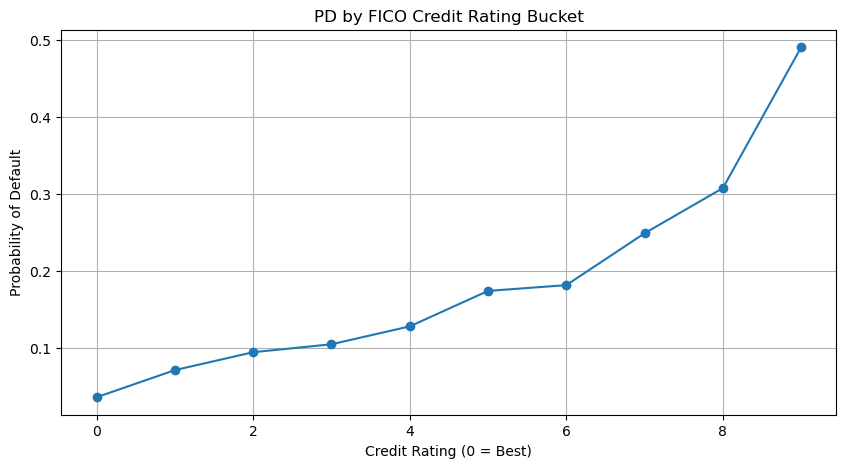

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(bucket_summary.index, bucket_summary['PD'], marker='o')
plt.xlabel("Credit Rating (0 = Best)")
plt.ylabel("Probability of Default")
plt.title("PD by FICO Credit Rating Bucket")
plt.grid(True)
plt.show()


#### **Step 10: Create a Production-Ready Rating Assignment Function**
In real systems, we need a **reusable function** that:

- Takes a FICO score as input

- Returns:

   - Credit rating

   - Associated PD

In [52]:
def assign_fico_rating(fico_score, rating_map):
    """
    Assigns a credit rating and PD based on FICO score
    """
    for _, row in rating_map.iterrows():
        if row['min_fico'] <= fico_score <= row['max_fico']:
            return int(row['credit_rating']), row['PD']
    return None, None


In [56]:
rating_map = (
    bucket_summary
    .reset_index()
    .rename(columns={'fico_bucket': 'credit_rating'})
)

rating_map


,credit_rating,min_fico,max_fico,PD,borrowers,PD_diff
0,0,715,850,0.036437,988,NaN
1,1,689,714,0.071642,1005,0.035205
2,2,671,688,0.094845,970,0.023204
3,3,654,670,0.105161,1027,0.010315
4,4,639,653,0.128385,997,0.023224
5,5,624,638,0.174395,992,0.046010
6,6,608,623,0.181911,984,0.007515
7,7,588,607,0.249240,987,0.067330
8,8,561,587,0.307841,1033,0.058601
9,9,408,560,0.490659,1017,0.182818


#### **Step 11: Test the Rating Function**

In [58]:
test_scores = [820, 720, 680, 640, 600, 550]

for score in test_scores:
    rating, pd = assign_fico_rating(score, rating_map)
    print(f"FICO: {score} → Rating: {rating}, PD: {pd:.2%}")


FICO: 820 → Rating: 0, PD: 3.64%
FICO: 720 → Rating: 0, PD: 3.64%
FICO: 680 → Rating: 2, PD: 9.48%
FICO: 640 → Rating: 4, PD: 12.84%
FICO: 600 → Rating: 7, PD: 24.92%
FICO: 550 → Rating: 9, PD: 49.07%


rating_map exists: True
assign_fico_rating exists: True


#### **Step 14: Stability & Sanity Checks (Model Governance)**

In real banking environments, models are not judged only on accuracy.
They must also be:

- Stable across segments

- Interpretable

- Robust to data variation

- Suitable for governance and validation


We now perform additional diagnostics to validate the quality of the FICO bucketing.

#### **Step 15: Borrower Distribution Check**

A good rating system should not:

- Overload one bucket

- Create very small, noisy buckets

In [63]:
bucket_summary['borrower_pct'] = (
    bucket_summary['borrowers'] / bucket_summary['borrowers'].sum()
)

bucket_summary[['borrowers', 'borrower_pct']]


,borrowers,borrower_pct
fico_bucket,,
0,988,0.0988
1,1005,0.1005
2,970,0.0970
3,1027,0.1027
4,997,0.0997
5,992,0.0992
6,984,0.0984
7,987,0.0987
8,1033,0.1033


#### **Step 16: PD Smoothness Check (Risk Discipline)**

Risk models prefer **smooth PD transitions** rather than sudden jumps.

We quantify how PD changes between adjacent buckets.

In [66]:
bucket_summary['PD_change'] = bucket_summary['PD'].diff()
bucket_summary[['PD', 'PD_change']]


,PD,PD_change
fico_bucket,,
0,0.036437,NaN
1,0.071642,0.035205
2,0.094845,0.023204
3,0.105161,0.010315
4,0.128385,0.023224
5,0.174395,0.046010
6,0.181911,0.007515
7,0.249240,0.067330
8,0.307841,0.058601


#### **Step 17: Kolmogorov–Smirnov (KS) Statistic**

KS is widely used in credit risk to measure **discriminatory power.**

- KS > 30% → acceptable

- KS > 40% → strong

- KS > 50% → excellent

In [70]:
def ks_statistic(df, score_col, target_col):
    df = df.sort_values(score_col)
    df['cum_default'] = df[target_col].cumsum() / df[target_col].sum()
    df['cum_non_default'] = (
        (1 - df[target_col]).cumsum() / (1 - df[target_col]).sum()
    )
    return np.max(np.abs(df['cum_default'] - df['cum_non_default']))


In [72]:
ks = ks_statistic(fico_df, 'fico_score', 'default')
ks


0.34050447105533554

#### **Step 18: Final Credit Rating Policy Table (Executive View)**

This table can be directly shown to:

- Risk committees

- Model validation

- Senior management

In [75]:
final_rating_policy = rating_map.copy()

final_rating_policy['risk_label'] = [
    "Excellent",
    "Very Good",
    "Good",
    "Moderate",
    "Average",
    "Below Average",
    "Weak",
    "Risky",
    "Very Risky",
    "High Risk"
]

final_rating_policy


,credit_rating,min_fico,max_fico,PD,borrowers,PD_diff,risk_label
0,0,715,850,0.036437,988,NaN,Excellent
1,1,689,714,0.071642,1005,0.035205,Very Good
2,2,671,688,0.094845,970,0.023204,Good
3,3,654,670,0.105161,1027,0.010315,Moderate
4,4,639,653,0.128385,997,0.023224,Average
5,5,624,638,0.174395,992,0.046010,Below Average
6,6,608,623,0.181911,984,0.007515,Weak
7,7,588,607,0.249240,987,0.067330,Risky
8,8,561,587,0.307841,1033,0.058601,Very Risky
9,9,408,560,0.490659,1017,0.182818,High Risk


In [ ]:
##Step 19: How This Integrates Into JPMorgan Systems

This rating framework can be plugged into:

Mortgage PD models

Expected Credit Loss (ECL)

IFRS 9 / CECL provisioning

Automated underwriting engines

Portfolio stress testing